In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image, ImageDraw
import torch.nn.functional as F
from diffusion import (
    get_ddpm_constants,
    DiffusionUNetLegacy,
    forward_sample,
    eval_ddpm_2d,
)
from util import (
    get_torch_size_string,
    plot_ddpm_2d_result,
)
from dataset import mnist
np.set_printoptions(precision=3)
th.set_printoptions(precision=3)
plt.rc('xtick',labelsize=8)
plt.rc('ytick',labelsize=8)
%matplotlib inline
%config InlineBackend.figure_format='retina'
print ("PyTorch version:[%s]."%(th.__version__))

# 이미지 데이터셋 클래스 정의
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, img) for img in os.listdir(root_dir) if img.endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

    def create_masked_images(self, images, min_mask_size=10, max_mask_size=50, max_masks=10):
        masked_images, masks = [], []
        transform_to_pil = transforms.ToPILImage()
        transform_to_tensor = transforms.ToTensor()
        
        for image in images:
            image = transform_to_pil(image)
            width, height = image.size
            mask = Image.new('L', (width, height), 0)

            num_masks = np.random.randint(1, max_masks + 1)

            for _ in range(num_masks):
                mask_size = np.random.randint(min_mask_size, max_mask_size)
                top_left_x = np.random.randint(0, width - mask_size)
                top_left_y = np.random.randint(0, height - mask_size)

                draw = ImageDraw.Draw(mask)
                draw.rectangle([top_left_x, top_left_y, top_left_x + mask_size, top_left_y + mask_size], fill=255)

                masked_image = image.copy()
                masked_image.paste((0, 0, 0), (top_left_x, top_left_y, top_left_x + mask_size, top_left_y + mask_size))

            masked_images.append(transform_to_tensor(masked_image))
            masks.append(transform_to_tensor(mask))
        
        return th.stack(masked_images), th.stack(masks)

# 이미지 변환
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# 데이터셋 준비
dataset = CustomImageDataset(root_dir='datasets/suwon', transform=transform)

# 데이터셋 분할
total_size = len(dataset)
valid_size = test_size = int(total_size * 0.1)
train_size = total_size - valid_size - test_size

train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)



In [ ]:
dc = get_ddpm_constants(
    schedule_name = 'cosine', # 'linear', 'cosine'
    T             = 1000,
    np_type       = np.float32,
)
device = 'cuda' # mps, cpu
print ("device:[%s]"%(device))

In [6]:
# 모델 인스턴스 생성
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DiffusionUNetLegacy(
    name='unet',
    dims=2,
    n_in_channels=3,  # 입력 채널을 3으로 설정
    n_base_channels=64,
    n_emb_dim=128,
    n_enc_blocks=4,
    n_dec_blocks=4,
    n_groups=16,
    n_heads=4,
    actv=nn.SiLU(),
    kernel_size=3,
    padding=1,
    use_attention=False,
    skip_connection=True,
    chnnel_multiples=(1, 2, 4, 8),
    updown_rates=(1, 2, 1, 2),
    use_scale_shift_norm=True,
    device=device
).to(device)

# 파라미터 확인
print("모델 파라미터 수:", sum(p.numel() for p in model.parameters() if p.requires_grad))

# 옵티마이저 설정
optm = th.optim.AdamW(params=model.parameters(), lr=1e-4, weight_decay=0.0)
schd = th.optim.lr_scheduler.ExponentialLR(optimizer=optm, gamma=0.99998)


모델 파라미터 수: 16646211


In [7]:

class DiffusionUNetLegacy(nn.Module):
    def __init__(self, name, dims, n_in_channels, n_base_channels, n_emb_dim, n_enc_blocks, n_dec_blocks, n_groups, n_heads, actv, kernel_size, padding, use_attention, skip_connection, chnnel_multiples, updown_rates, use_scale_shift_norm, device):
        super(DiffusionUNetLegacy, self).__init__()
        
        # 예시 U-Net 구조 (간략화된 버전)
        self.encoder = nn.Sequential(
            nn.Conv2d(n_in_channels + 1, n_base_channels, kernel_size=kernel_size, padding=padding),  # 입력 채널 수정
            nn.ReLU(),
            nn.Conv2d(n_base_channels, n_base_channels * 2, kernel_size=kernel_size, padding=padding),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.Conv2d(n_base_channels * 2, n_base_channels, kernel_size=kernel_size, padding=padding),
            nn.ReLU(),
            nn.Conv2d(n_base_channels, 3, kernel_size=kernel_size, padding=padding),  # 출력 채널을 3으로 설정
            nn.Sigmoid()
        )

    def forward(self, x, mask):
        x = torch.cat((x, mask), dim=1)  # [B x (C+1) x H x W], C는 3, mask는 1
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
# 모델 인스턴스 생성
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DiffusionUNetLegacy(
    name='unet',
    dims=2,
    n_in_channels=3,  # 입력 채널을 3으로 설정
    n_base_channels=64,
    n_emb_dim=128,
    n_enc_blocks=4,
    n_dec_blocks=4,
    n_groups=16,
    n_heads=4,
    actv=nn.SiLU(),
    kernel_size=3,
    padding=1,
    use_attention=False,
    skip_connection=True,
    chnnel_multiples=(1, 2, 4, 8),
    updown_rates=(1, 2, 1, 2),
    use_scale_shift_norm=True,
    device=device
).to(device)

# 파라미터 확인
print("모델 파라미터 수:", sum(p.numel() for p in model.parameters() if p.requires_grad))

# 옵티마이저 설정
optm = th.optim.AdamW(params=model.parameters(), lr=1e-4, weight_decay=0.0)
schd = th.optim.lr_scheduler.ExponentialLR(optimizer=optm, gamma=0.99998)


모델 파라미터 수: 151747


In [9]:
from skimage.metrics import structural_similarity as ssim
import torch
import torch.nn.functional as F

def ssim_loss(predicted, target):
    ssim_val = ssim(predicted.cpu().numpy().transpose(0, 2, 3, 1), target.cpu().numpy().transpose(0, 2, 3, 1), multichannel=True, data_range=1.0)
    ssim_loss = 1 - ssim_val
    return torch.tensor(ssim_loss, device=predicted.device)

def psnr_loss(predicted, target):
    mse_loss = F.mse_loss(predicted, target)
    psnr_val = 10 * torch.log10(1 / mse_loss)
    psnr_loss = -psnr_val  
    return psnr_loss

# 설정
max_iter = int(1e4)
batch_size = 16
print_every = 1e3
eval_every = 2e3

# 학습 루프
model.train()
for it in range(max_iter):
    for batch in train_loader:
        original_images = batch.to(device)
        
        # 원래 데이터셋 객체 참조
        dataset = train_loader.dataset.dataset
        masked_images, masks = dataset.create_masked_images(original_images)
        
        masked_images = masked_images.to(device)
        masks = masks.to(device)

        timesteps = torch.randint(0, dc['T'], (masked_images.size(0),), device=device).long()

        optm.zero_grad()

        # idx = np.random.choice(x_0.shape[0],batch_size)
        # x_0_batch = x_0[idx,:,:,:] # [B x C x W x H]
        # # Forward diffusion sampling
        # x_t_batch,noise = forward_sample(x_0_batch,step_batch,dc) # [B x C x W x H]
        
        ######################
        output = model(masked_images, masks)
        loss = F.mse_loss(output, original_images) + F.smooth_l1_loss(output, original_images, beta=0.1)
        ######################
        
        
        ######################
        # masked_output, noise_pred = model(masked_images, timesteps, masks)
        # # 노이즈 예측 손실 (디퓨전 모델용)
        # noise = torch.randn_like(masked_images)  # 가정: 노이즈가 Gaussian 형태임
        # diffusion_loss = F.mse_loss(noise_pred, noise)
        # # 마스크된 영역 복원 손실
        # reconstruction_loss = F.mse_loss(masked_output * masks, original_images * masks) + F.smooth_l1_loss(masked_output * masks, original_images * masks, beta=0.1)
        # # 총 손실
        # loss = diffusion_loss + reconstruction_loss
        ######################

        

        # ######################
        # # 모델에 masked_images와 timesteps를 전달하고, masked_output과 noise_pred를 받아옴
        # masked_output, noise_pred = model(masked_images, timesteps, masks)

        # # 노이즈 예측 손실 (디퓨전 모델용)
        # noise = torch.randn_like(masked_images)  # 가정: 노이즈가 Gaussian 형태임
        # diffusion_loss = F.mse_loss(noise_pred, noise)

        # # 마스크된 영역 복원 손실
        # reconstruction_loss = F.mse_loss(masked_output * masks, original_images * masks) + F.smooth_l1_loss(masked_output * masks, original_images * masks, beta=0.1)
        
        # # 총 손실
        # loss = diffusion_loss + reconstruction_loss
        # #############################
        #         # 마스크를 포함한 입력 구성
        # masked_images_with_mask = torch.cat([masked_images, masks], dim=1)  # [B, 2, H, W]

        # # 모델에 masked_images_with_mask와 timesteps를 전달하고, masked_output과 noise_pred를 받아옴
        # masked_output, noise_pred = model(masked_images_with_mask, timesteps)

        # # 노이즈 예측 손실 (디퓨전 모델용)
        # noise = torch.randn_like(masked_images)  # 가정: 노이즈가 Gaussian 형태임
        # diffusion_loss = F.mse_loss(noise_pred, noise)

        # # 마스크된 영역 복원 손실 (SSIM 및 PSNR 손실 사용)
        # ssim_loss_val = ssim_loss(masked_output * masks, original_images * masks)
        # psnr_loss_val = psnr_loss(masked_output * masks, original_images * masks)
        # reconstruction_loss = ssim_loss_val + psnr_loss_val

        # # 총 손실
        # loss = diffusion_loss + reconstruction_loss
        ##############################
        
        loss.backward()
        optm.step()
        schd.step()

        if (it % print_every) == 0 or it == (max_iter - 1):
            print(f'Iteration {it}, Loss: {loss.item()}')

        if (it % eval_every) == 0 or it == (max_iter - 1):
            # 모델 평가 및 결과 시각화 코드 추가 가능
            pass

print("Training complete.")


Iteration 0, Loss: 0.5485669374465942
Iteration 0, Loss: 0.5447279214859009
Iteration 0, Loss: 0.5282419919967651
Iteration 0, Loss: 0.5107958912849426
Iteration 0, Loss: 0.5073379278182983
Iteration 0, Loss: 0.4743615984916687
Iteration 1000, Loss: 0.0034279217943549156
Iteration 1000, Loss: 0.004333076998591423
Iteration 1000, Loss: 0.005694832652807236
Iteration 1000, Loss: 0.005920423194766045
Iteration 1000, Loss: 0.005191805772483349
Iteration 1000, Loss: 0.006732483860105276
Iteration 2000, Loss: 0.004689579363912344
Iteration 2000, Loss: 0.007584161590784788
Iteration 2000, Loss: 0.004694647155702114
Iteration 2000, Loss: 0.0017816531471908092
Iteration 2000, Loss: 0.002984574530273676
Iteration 2000, Loss: 0.0017663121689110994
Iteration 3000, Loss: 0.003985357470810413
Iteration 3000, Loss: 0.007256210315972567
Iteration 3000, Loss: 0.0024701885413378477
Iteration 3000, Loss: 0.003028806298971176
Iteration 3000, Loss: 0.004497577901929617
Iteration 3000, Loss: 0.0059527726843

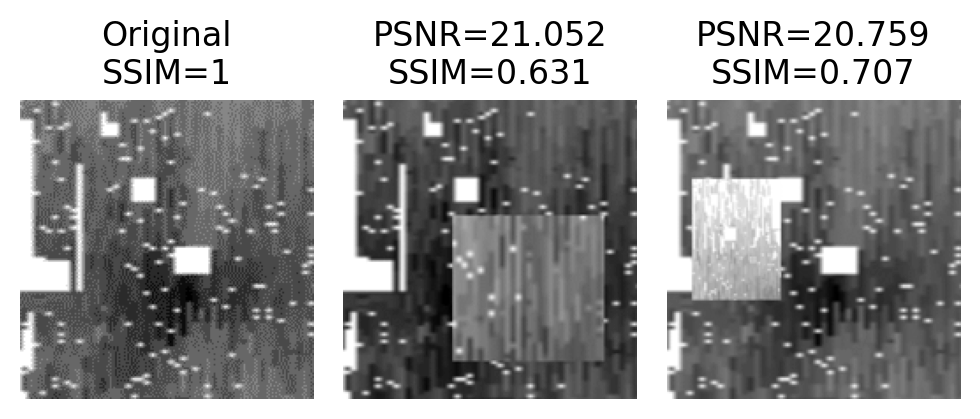

In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr
from PIL import Image

# Load images
original = Image.open('datasets/valid/original.png').convert('L')
modified_a = Image.open('datasets/valid/a.png').convert('L')
modified_b = Image.open('datasets/valid/b.png').convert('L')

# Resize modified images to match the original image's size
original_size = original.size
modified_a = modified_a.resize(original_size)
modified_b = modified_b.resize(original_size)

# Convert images to numpy arrays
original_np = np.array(original)
modified_a_np = np.array(modified_a)
modified_b_np = np.array(modified_b)

# Calculate PSNR and SSIM
psnr_a = psnr(original_np, modified_a_np)
ssim_a = ssim(original_np, modified_a_np)

psnr_b = psnr(original_np, modified_b_np)
ssim_b = ssim(original_np, modified_b_np)

# Plot the images
fig, axes = plt.subplots(1, 3, figsize=(5, 10))
axes[0].imshow(original_np, cmap='gray')
axes[0].set_title(f'Original\nSSIM=1')
axes[0].axis('off')

axes[1].imshow(modified_a_np, cmap='gray')
axes[1].set_title(f'PSNR={psnr_a:.3f}\nSSIM={ssim_a:.3f}')
axes[1].axis('off')

axes[2].imshow(modified_b_np, cmap='gray')
axes[2].set_title(f'PSNR={psnr_b:.3f}\nSSIM={ssim_b:.3f}')
axes[2].axis('off')

plt.tight_layout()
plt.show()


### using diffusion.py model -> memory problem : para = 16646211

In [27]:
# 설정
max_iter = int(1e4)
batch_size = 16
print_every = 1e3
eval_every = 2e3

# 학습 루프
model.train()
for it in range(max_iter):
    for batch in train_loader:
        original_images = batch.to(device)
        
        # 원래 데이터셋 객체 참조
        dataset = train_loader.dataset.dataset
        masked_images, masks = dataset.create_masked_images(original_images)
        
        masked_images = masked_images.to(device)
        masks = masks.to(device)

        timesteps = torch.randint(0, dc['T'], (masked_images.size(0),), device=device).long()

        optm.zero_grad()

        ######################
        # 모델에 masked_images와 timesteps를 전달하고, masked_output과 noise_pred를 받아옴
        masked_output, noise_pred = model(masked_images, timesteps, masks)

        # 노이즈 예측 손실 (디퓨전 모델용)
        noise = torch.randn_like(masked_images)  # 가정: 노이즈가 Gaussian 형태임
        diffusion_loss = F.mse_loss(noise_pred, noise)

        # 마스크된 영역 복원 손실
        reconstruction_loss = F.mse_loss(masked_output * masks, original_images * masks) + F.smooth_l1_loss(masked_output * masks, original_images * masks, beta=0.1)
        
        # 총 손실
        loss = diffusion_loss + reconstruction_loss
        
        loss.backward()
        optm.step()
        schd.step()

        if (it % print_every) == 0 or it == (max_iter - 1):
            print(f'Iteration {it}, Loss: {loss.item()}')

        if (it % eval_every) == 0 or it == (max_iter - 1):
            # 모델 평가 및 결과 시각화 코드 추가 가능
            pass

print("Training complete.")


OutOfMemoryError: CUDA out of memory. Tried to allocate 192.00 MiB. GPU 0 has a total capacty of 10.75 GiB of which 71.69 MiB is free. Including non-PyTorch memory, this process has 10.67 GiB memory in use. Of the allocated memory 9.81 GiB is allocated by PyTorch, and 469.43 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

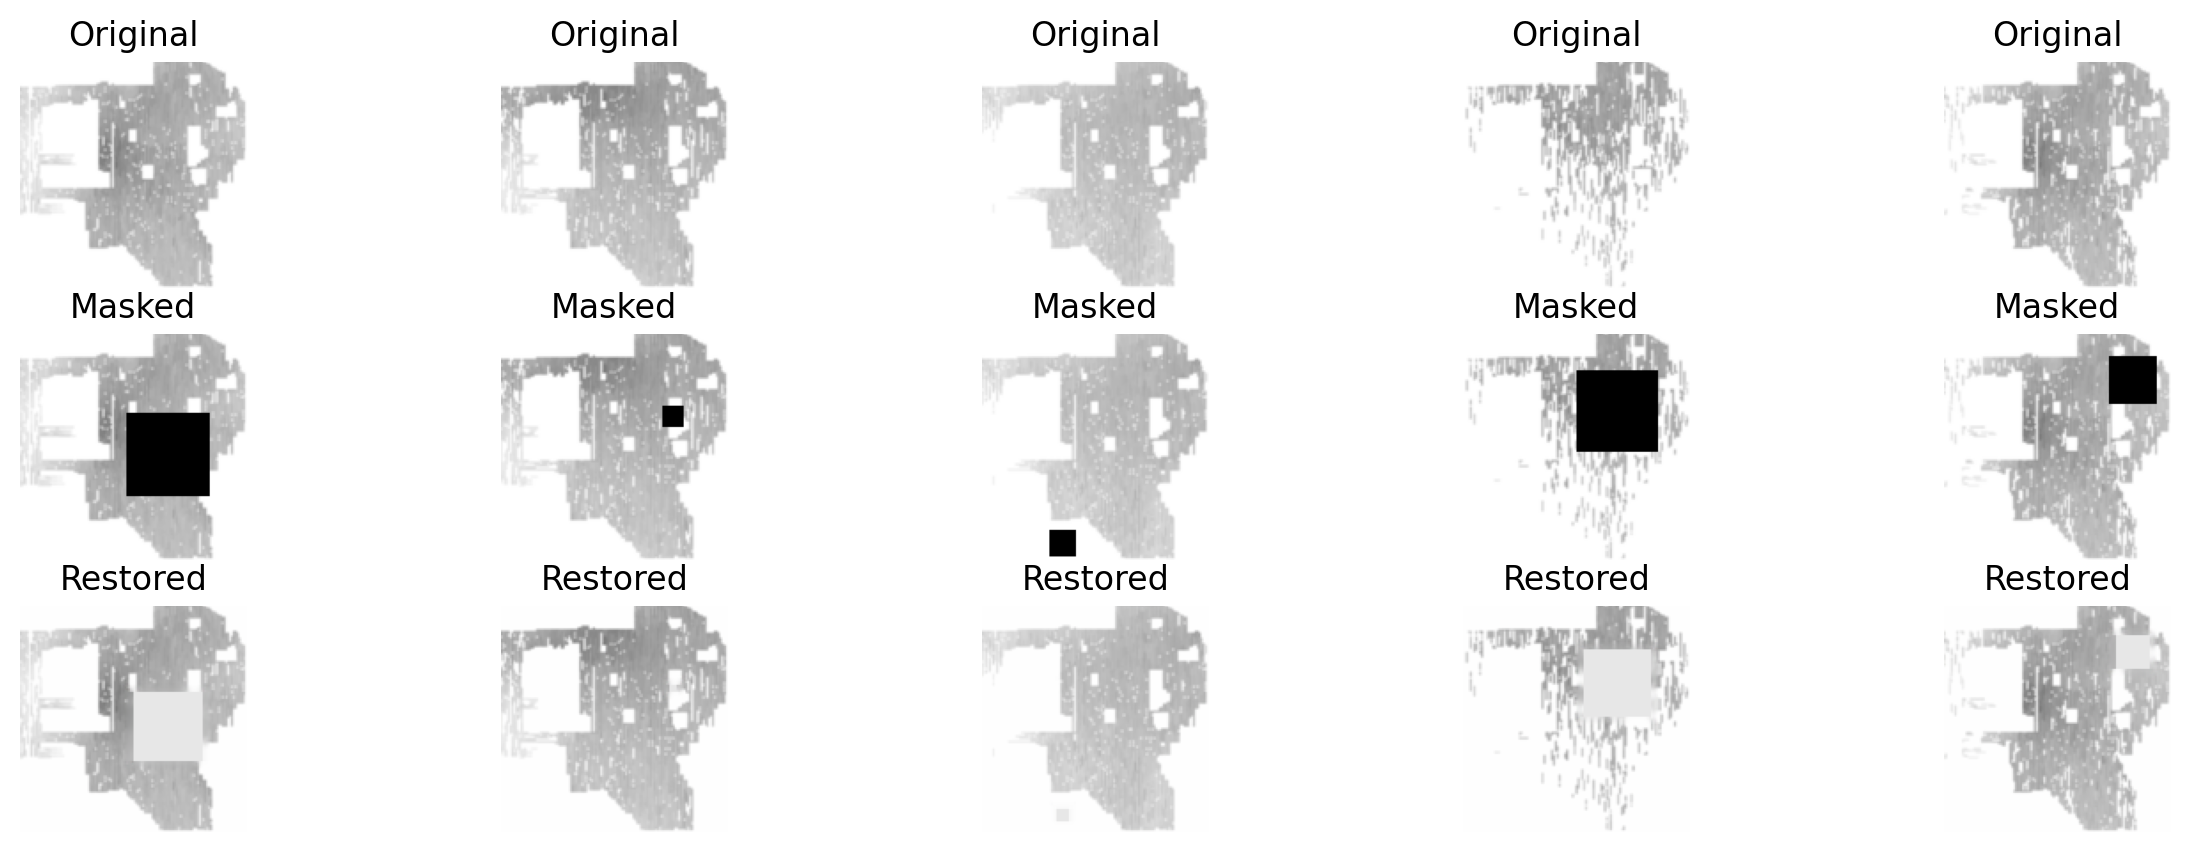

Validation Loss: 0.0047


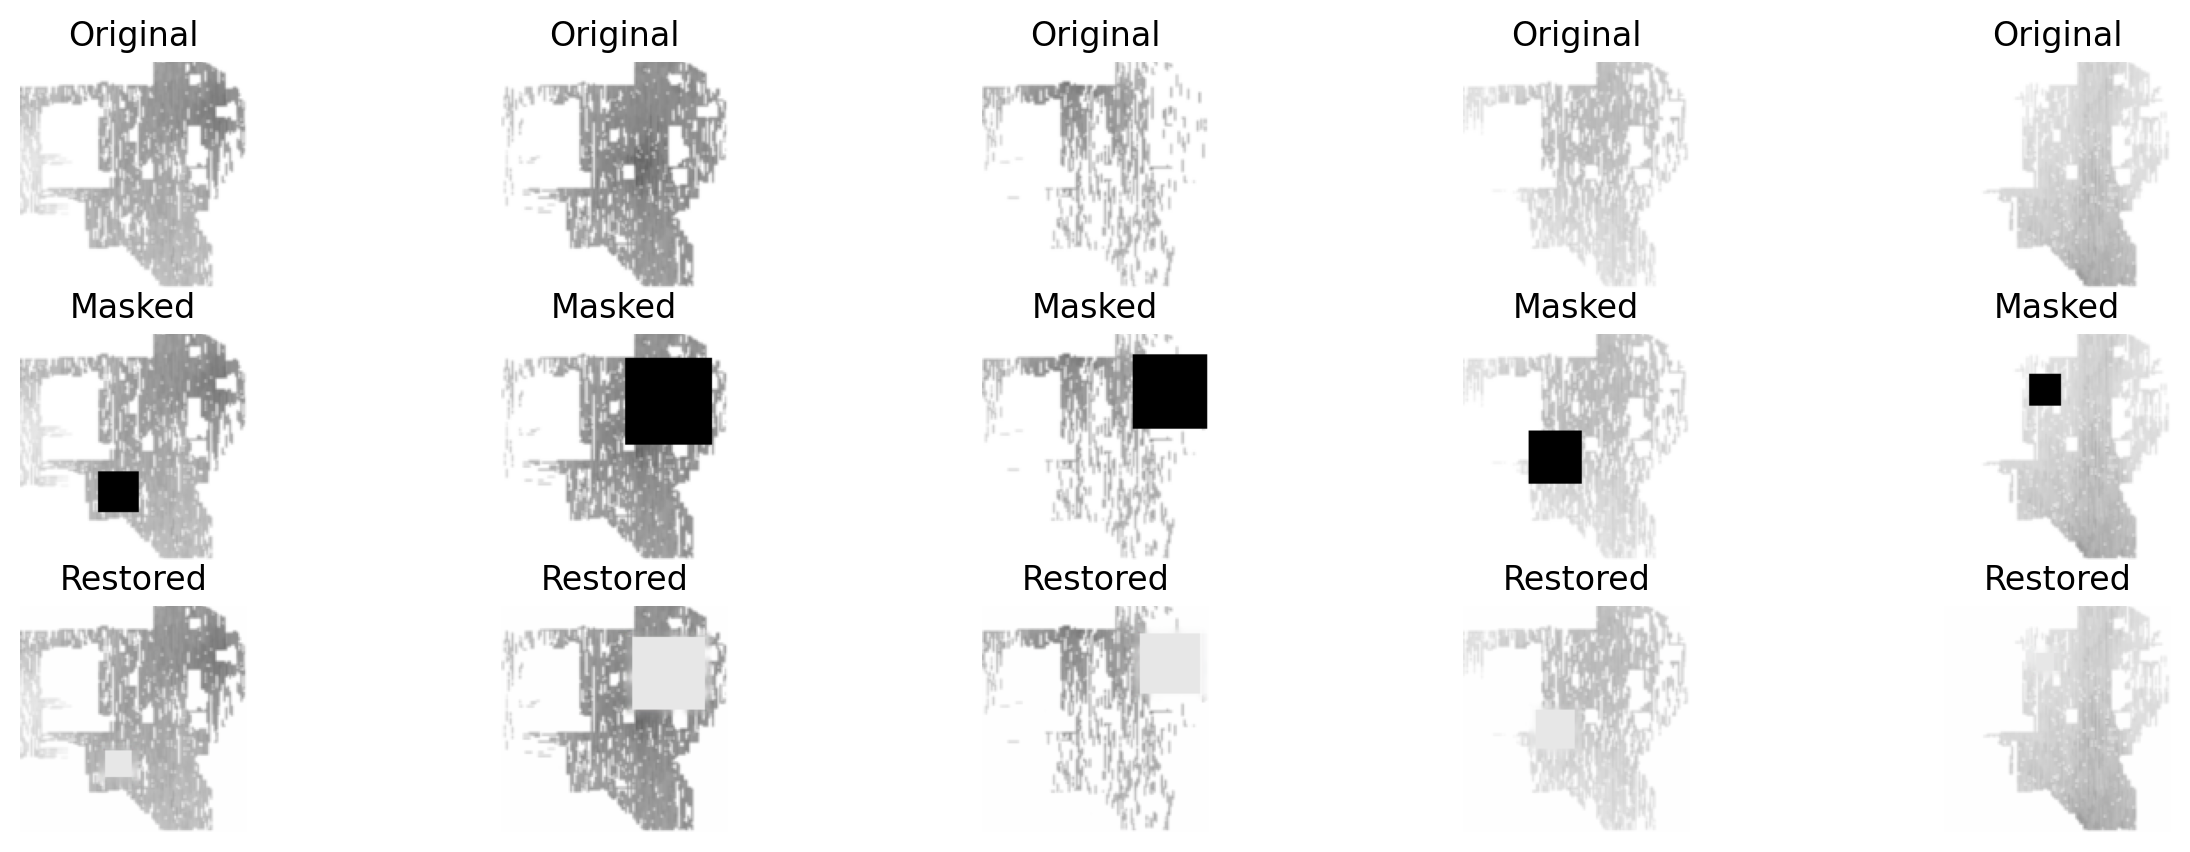

Validation Loss: 0.0051


In [11]:
# 평가 코드
def plot_images(original_images, masked_images, output_images, n=5):
    plt.figure(figsize=(15, 5))
    for i in range(n):
        # 원본 이미지
        plt.subplot(3, n, i + 1)
        plt.imshow(original_images[i].cpu().permute(1, 2, 0))
        plt.axis('off')
        plt.title('Original')

        # 마스크된 이미지
        plt.subplot(3, n, i + 1 + n)
        plt.imshow(masked_images[i].cpu().permute(1, 2, 0))
        plt.axis('off')
        plt.title('Masked')

        # 복원된 이미지
        plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(output_images[i].cpu().permute(1, 2, 0))
        plt.axis('off')
        plt.title('Restored')

    plt.show()

def evaluate(model, dataloader, device, plot=False):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in dataloader:
            original_images = batch.to(device)
            dataset = dataloader.dataset.dataset
            masked_images, masks = dataset.create_masked_images(original_images)

            masked_images = masked_images.to(device)
            masks = masks.to(device)

            output = model(masked_images, masks)

            # 마스크된 부분만 손실 계산
            loss = F.mse_loss(output * masks, original_images * masks) + F.smooth_l1_loss(output * masks, original_images * masks, beta=0.1)
            total_loss += loss.item()

            if plot:
                # 이미지 시각화
                plot_images(original_images, masked_images, output)

    avg_loss = total_loss / len(dataloader)
    print(f'Validation Loss: {avg_loss:.4f}')

# 검증 데이터셋 평가
evaluate(model, valid_loader, device, plot=True)

# 테스트 데이터셋 평가
evaluate(model, test_loader, device, plot=True)